In [1]:
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
import pandas as pd

from utils import *

In [2]:
device = torch.device('cuda:1')

In [78]:
class args:
    result_dir = '../results/cicidsv3.0'
    batch_size = 256
    dataset = "2017"
    exp=1
    epochs = 30

In [79]:
if args.dataset =="2017":
    from main_utils import exp_label_2017
    lab_cluster, lab_dic, lab_name, ooc_cols = exp_label_2017(args.exp)   
    from main_utils import lab_2017 as lab_name_tot
else:
    from main_utils import exp_label_2018
    lab_cluster, lab_dic, lab_name, ooc_cols = exp_label_2018(args.exp)
    from main_utils import lab_2018 as lab_name_tot 

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS slowloris': 1, 'DoS Slowhttptest': 1, 'DDoS': 2, 'Bot': 3, 'PortScan': 4, 'FTP-Patator': 5, 'SSH-Patator': 5}


In [80]:
train_df = pd.read_parquet(os.path.join(args.result_dir,"cicids%s_traindf.parquet"%args.dataset))
test_df = pd.read_parquet(os.path.join(args.result_dir,"cicids%s_testdf.parquet"%args.dataset))

In [81]:
cicids_bn = load_cicids_binary_data(args.dataset, lab_cluster, lab_name, args.result_dir,
                                       return_scaler=True, ooc_cols=None)
cicids_m = load_cicids_mult_data(args.dataset, lab_dic, lab_name, args.result_dir,
                                       return_scaler=True, ooc_cols=None)

drop Benign
drop Infiltration
drop Heartbleed
drop Web Attack  Sql Injection
original instances:  1040360
drop intances:  751122
after drop:  289238
drop Benign
drop Infiltration
drop Heartbleed
drop Web Attack  Sql Injection
original instances:  260090
drop intances:  187675
after drop:  72415


In [82]:
cicids_bn[4]

StandardScaler()

In [83]:
bn_save_model, mul_save_model = load_model_path(args.dataset, lab_name, args.epochs, 
                                                None, True, True)

In [84]:
n_features = cicids_m[0].shape[1]
n_class = len(np.unique(cicids_m[1]))
n_hidden = 32

clf_bn = BinaryNN(cicids2017_bn[0].shape[1])
clf_bn.load_state_dict(torch.load(os.path.join(args.result_dir, bn_save_model),map_location='cpu'))
clf_mul = MultNN(n_features, n_hidden, n_class)
clf_mul.load_state_dict(torch.load(os.path.join(result_dir, mul_save_model),map_location='cpu'))

<All keys matched successfully>

In [85]:
train_df[train_df['Label']=='Benign'].loc[:,train_df.columns!='Label'].shape

(751077, 67)

In [86]:
def dataloader_with_scaler(datadf, scaler, batch_size, shuffle):
    scaled_df = scaler.transform(datadf)
    label = np.zeros(datadf.shape[0])
    data_loader = make_dataloader(scaled_df, label, batch_size = batch_size, shuffle=shuffle)
    return data_loader

In [117]:
preds = {}

preds['trbn'] = []
preds['tebn'] = []
preds['trm'] = []
preds['tem'] = []

for lnt in ['Benign']+lab_name_tot:
    
    print("result for ", lnt)
    xtr = train_df[train_df['Label']==lnt].loc[:,train_df.columns!='Label']
    xte = test_df[test_df['Label']==lnt].loc[:,test_df.columns!='Label']
    trbnl = dataloader_with_scaler(xtr, cicids_bn[4], args.batch_size, False)
    tebnl = dataloader_with_scaler(xte, cicids_bn[4], args.batch_size, False)
    preds['trbn'].append(get_prediction(clf_bn, trbnl, device))
    preds['tebn'].append(get_prediction(clf_bn, tebnl, device))
    
    trml = dataloader_with_scaler(xtr, cicids_m[4], args.batch_size, False)
    teml = dataloader_with_scaler(xte, cicids_m[4], args.batch_size, False)
    preds['trm'].append(torch.softmax(get_prediction(clf_mul, trml, device),dim=1))
    preds['tem'].append(torch.softmax(get_prediction(clf_mul, teml, device),dim=1))
    
    

binary result for  Benign
binary result for  Web Attack  Brute Force
binary result for  Web Attack  XSS
binary result for  Web Attack  Sql Injection
binary result for  DoS Hulk
binary result for  DoS GoldenEye
binary result for  DoS slowloris
binary result for  DoS Slowhttptest
binary result for  DDoS
binary result for  Bot
binary result for  PortScan
binary result for  FTP-Patator
binary result for  SSH-Patator
binary result for  Heartbleed
binary result for  Infiltration


Benign


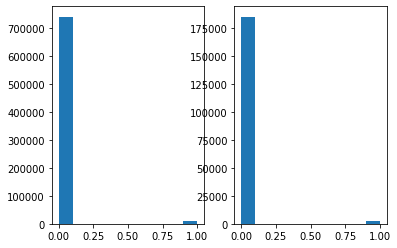

Web Attack  Brute Force


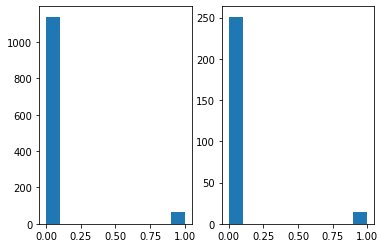

Web Attack  XSS


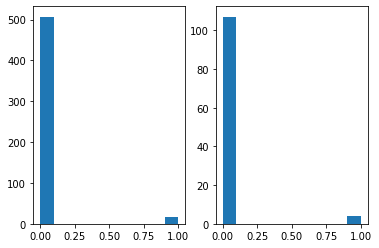

Web Attack  Sql Injection


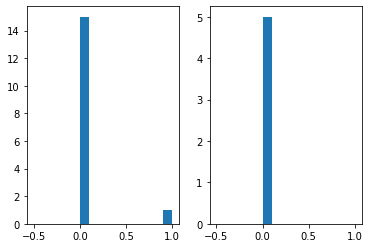

DoS Hulk


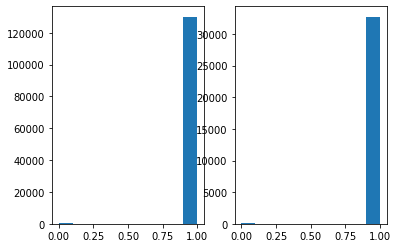

DoS GoldenEye


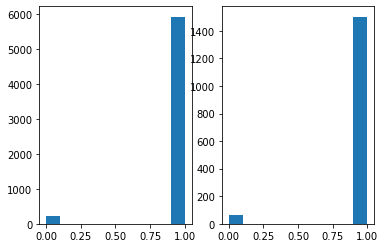

DoS slowloris


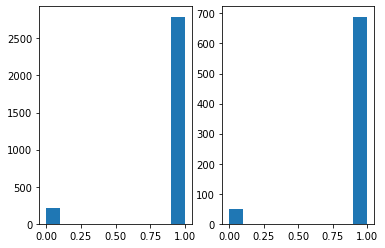

DoS Slowhttptest


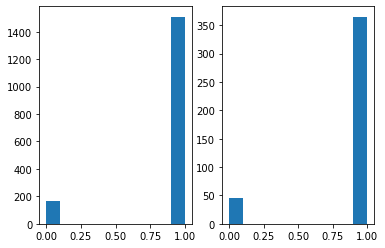

DDoS


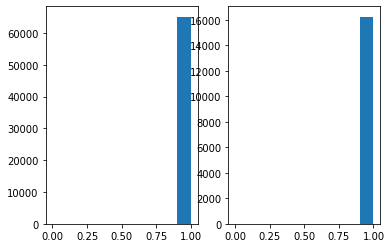

Bot


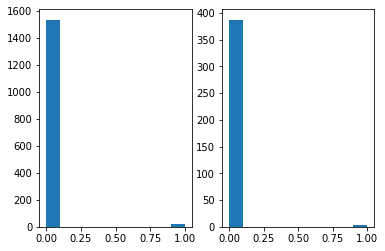

PortScan


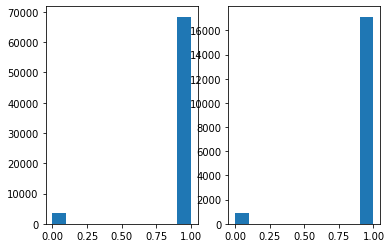

FTP-Patator


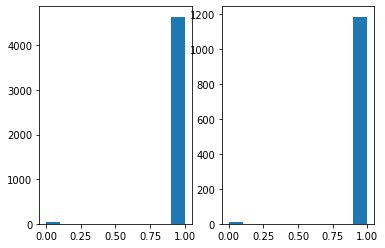

SSH-Patator


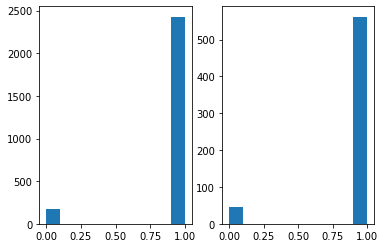

Heartbleed


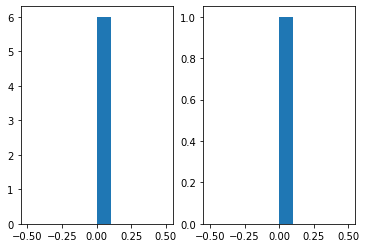

Infiltration


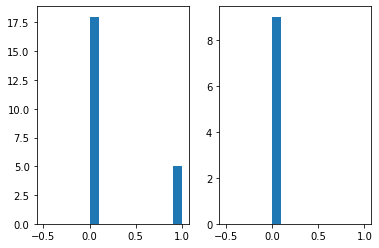

In [118]:
import matplotlib.pyplot as plt
for idx in range(len(lab_name_tot)+1):
    print((['Benign']+lab_name_tot)[idx])
    fig, ax = plt.subplots(1,2,sharex=True)
    ax[0].hist((preds['trbn'][idx]>0.5).numpy().astype(int).flatten())
    ax[1].hist((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
    plt.show()

In [102]:
lab_name

['Web_Attack', 'DoS_attacks', 'DDoS_attacks', 'Bot', 'PortScan', 'Bruteforce']

prediction results for  Benign
[0 1 2 3 4 5] [0 1 2 3 4 5]


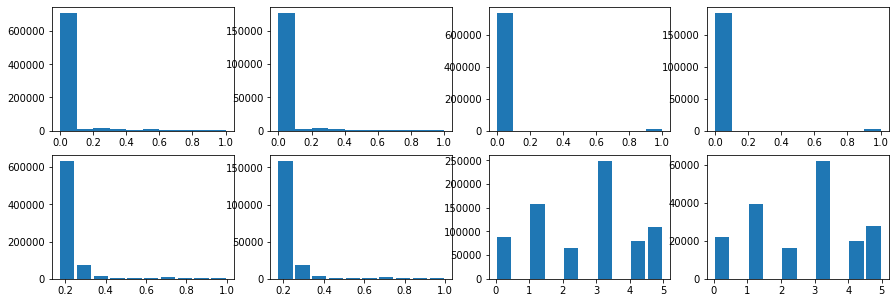

prediction results for  Web Attack  Brute Force
[0 1 4 5] [0 1 5]


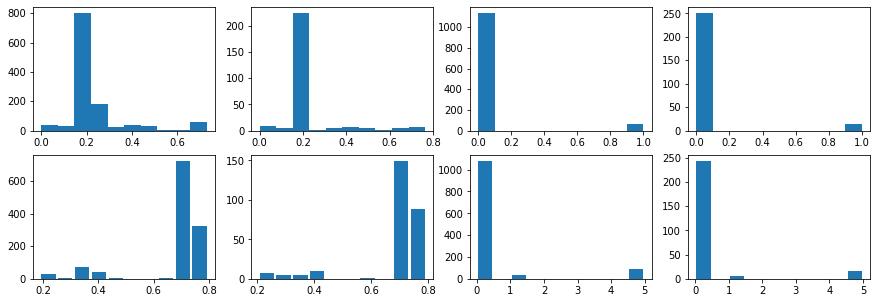

prediction results for  Web Attack  XSS
[0 1 4 5] [0 1 5]


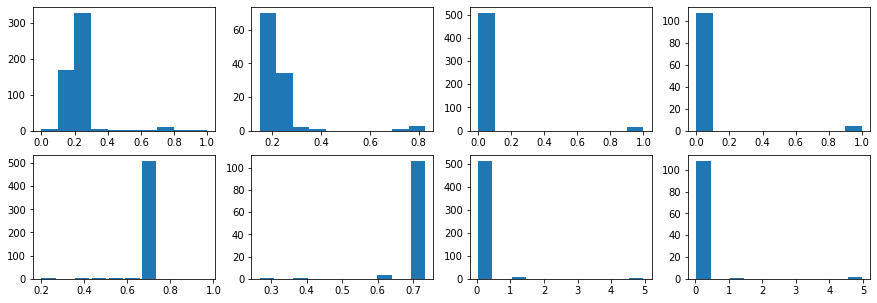

prediction results for  Web Attack  Sql Injection
[1 5] [1 5]


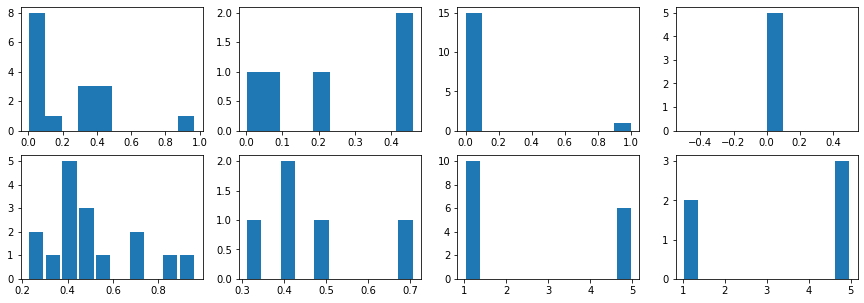

prediction results for  DoS Hulk
[0 1 2 3] [0 1 2]


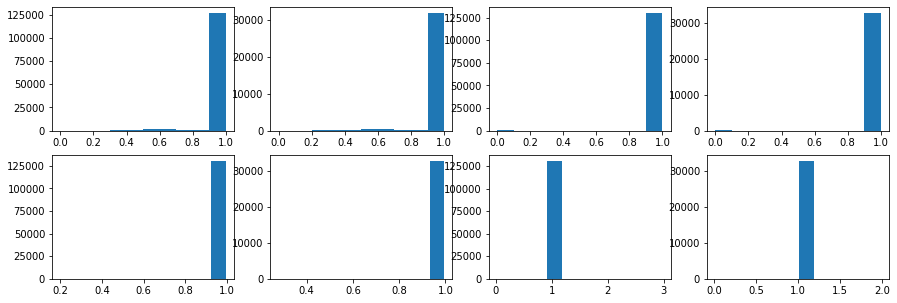

prediction results for  DoS GoldenEye
[1] [1]


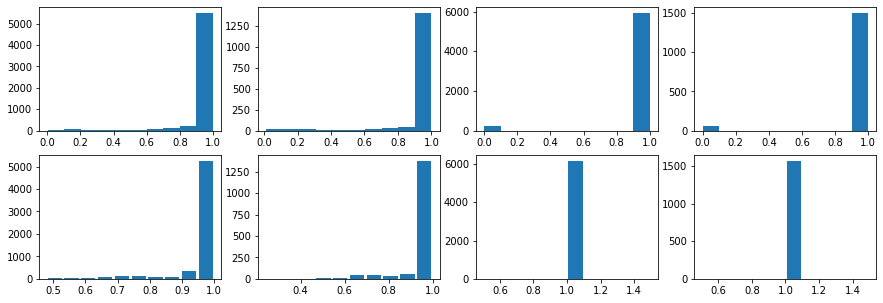

prediction results for  DoS slowloris
[0 1 3 4 5] [0 1 2 5]


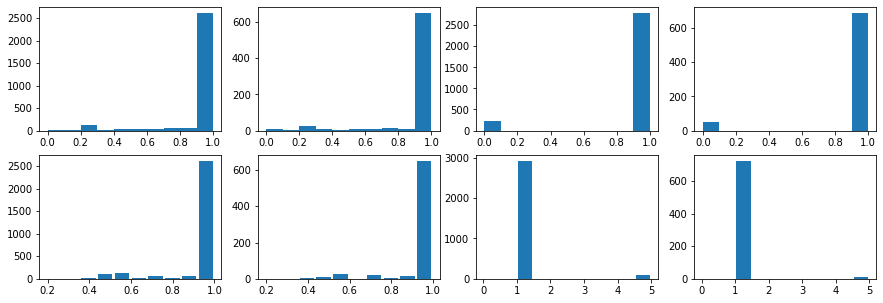

prediction results for  DoS Slowhttptest
[0 1 5] [1]


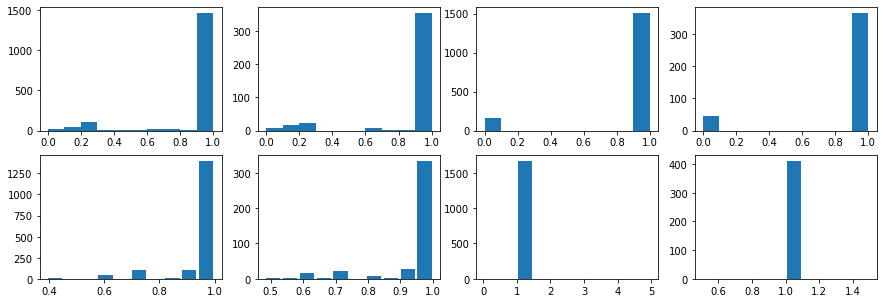

prediction results for  DDoS
[1 2 3] [1 2 3]


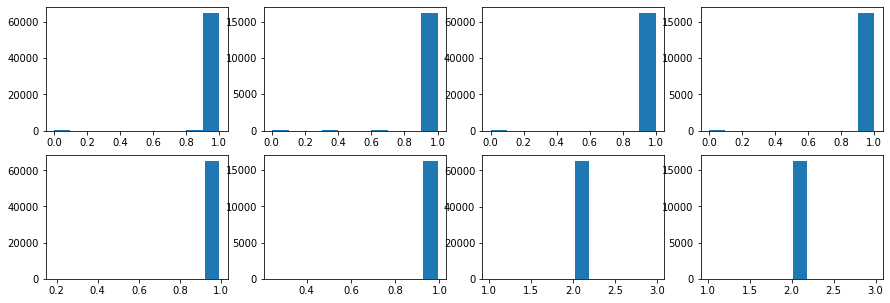

prediction results for  Bot
[2 3] [2 3]


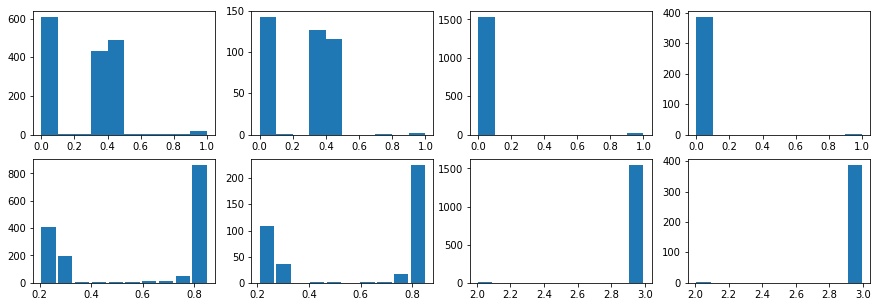

prediction results for  PortScan
[0 1 2 4 5] [0 1 4 5]


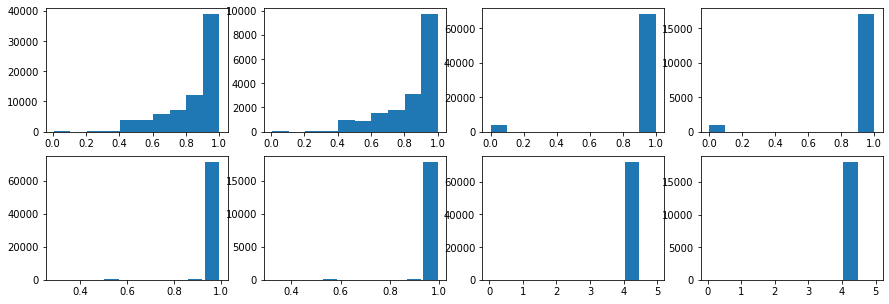

prediction results for  FTP-Patator
[0 1 4 5] [1 4 5]


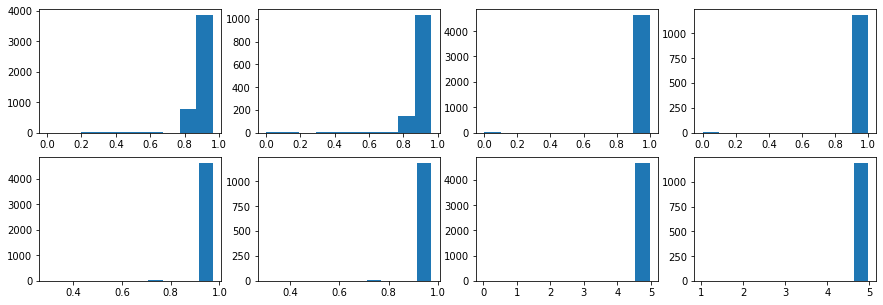

prediction results for  SSH-Patator
[1 4 5] [1 3 4 5]


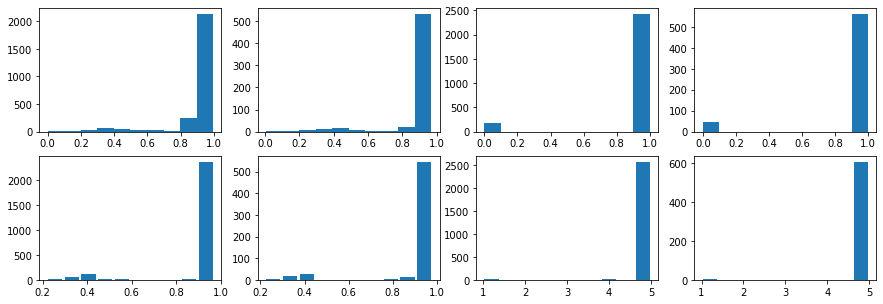

prediction results for  Heartbleed
[3] [3]


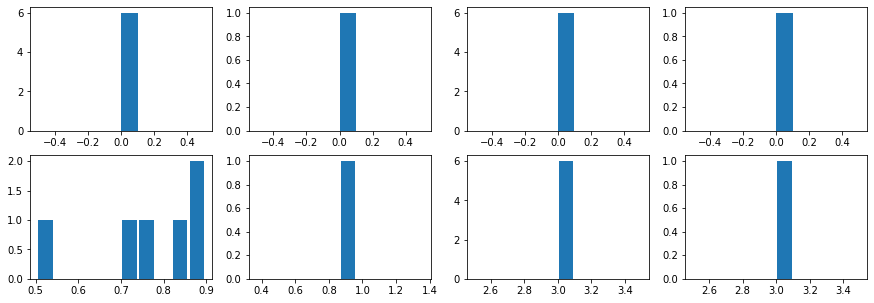

prediction results for  Infiltration
[0 1 2 3 5] [2 3]


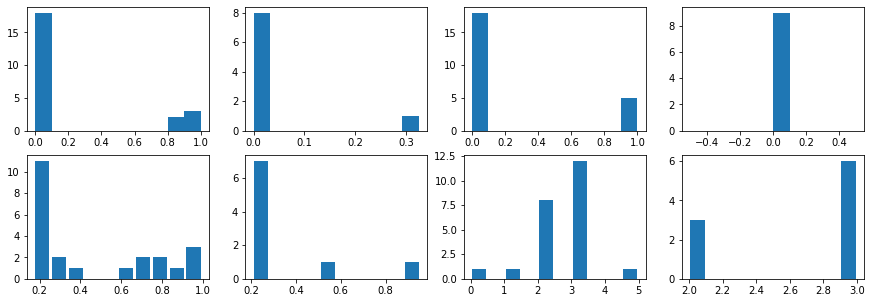

In [128]:
import matplotlib.pyplot as plt
for idx in range(len(lab_name_tot)+1):
    print('prediction results for ',(['Benign']+lab_name_tot)[idx])
    print(np.unique(torch.max(preds['trm'][idx],dim=1)[1].numpy()),np.unique(torch.max(preds['tem'][idx],dim=1)[1].numpy()))
    fig, ax = plt.subplots(2,4, figsize=(15,5))
    ax[0,0].hist((preds['trbn'][idx]).numpy().flatten())
    ax[0,1].hist((preds['tebn'][idx]).numpy().flatten())
    ax[0,2].hist((preds['trbn'][idx]>0.5).numpy().astype(int).flatten())
    ax[0,3].hist((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
    ax[1,0].hist(torch.max(preds['trm'][idx],dim=1)[0].numpy(),rwidth=0.85)
    ax[1,1].hist(torch.max(preds['tem'][idx],dim=1)[0].numpy(),rwidth=0.85)
    ax[1,2].hist(torch.max(preds['trm'][idx],dim=1)[1].numpy(),rwidth=0.85)
    ax[1,3].hist(torch.max(preds['tem'][idx],dim=1)[1].numpy(),rwidth=0.85)

    plt.show()

In [99]:
print((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
torch.max(preds['tem'][idx],dim=1)

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


torch.return_types.max(
values=tensor([0.4305, 0.3626, 0.2679, 0.3953, 0.6873, 0.4648, 0.8491, 0.9639, 0.4772,
        0.3965, 0.3919, 0.2234, 0.5281, 0.4783, 0.4287, 0.7073]),
indices=tensor([5, 5, 1, 5, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1]))